## Project Introduction
This project is a Django demo app to demonstrate some performance improvements and optimizations, using PostgreSQL as the database. 
Its first draft was written along an article blog: [10 tips  to Optimize your Django queries with PostgreSQL](https://blog.gitguardian.com/10-tips-to-optimize-postgresql-queries-in-your-django-project/) and was then further improved for [a DjangCon 2023 workshop](https://pretalx.com/djangocon-europe-2023/talk/DK3XET/)

It contains a single app, `books`, with the following models:
- `Library`, either public or private, depending on the number of books it contains. 
- `Book`
- `BookTag` for books also available on a specific media, or specific language, in a given library
- `Person`
- `Review`, written by a `Person` on a `Book` from a given `Library`


## Setup your project

### Django setup

In [1]:
import os
os.chdir("../..")
import django_init


In [2]:
# For better printing

from rich import print
from rich.console import Console
from rich.markdown import Markdown

console = Console()

In [3]:
from utils.perf_display import format_duration, perf_counter


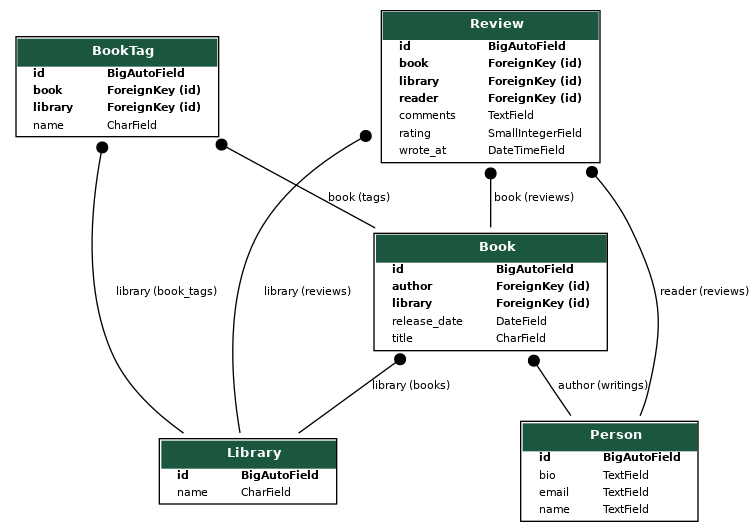

In [4]:
from IPython.core.display import Image
from django.core.management import call_command
call_command("graph_models", "books", output="model_graph.png")
Image("model_graph.png")

In [5]:
from books.models import Book, Library, BookTag, Review, Person
for model in [Library, Person, Book,  BookTag, Review]:
    print(f"{model.objects.count():_} {model._meta.verbose_name_plural}")

9_914 libraries

20_100 persons

4_001_000 books

11_998_353 book tags

40_005_191 reviews

## 1st exercice
Let's start with a simple example. 
We want to implement, for a given library, a API endpoint returning a JSON object `{book.title: reader_name_list}` for all the books in the library
A minimal implementation is available in [this file]("../../../../books/views/book/reader_per_book.py). 
In this example and the next ones, we'll also use a middle layer between views and models, called `selectors`, to write non-trivial queries.

In [6]:
from django.db.models import Count

# Get the library with the most books
library_alexandria_id, book_count = Book.objects.values("library_id").annotate(book_count=Count("id")).order_by(
    "-book_count"
).values_list("library_id", "book_count").first()
print("Library ID", library_alexandria_id, "book count", book_count)

alexandria = Library.objects.get(id=library_alexandria_id)
alexandria.name = "Alexandria"
alexandria.save()
print("Alexandria has", alexandria.books.count(), "books")

# id not from the 10 libraries with a lot of books
personal = Library.objects.get(id=100)
personal.name = "Personal"
personal.save()
print("Personal has", personal.books.count(), "books")

medium = Library.objects.order_by("-id").first()
medium.name = "Medium"
medium.save()
print("Medium has", medium.books.count(), "books")
medium_id = medium.id



Library ID 6 book count 200711

Alexandria has 200711 books

Personal has 210 books

Medium has 20113 books

In [7]:
# Let's try the existing endpoint
from rest_framework.test import APIClient
client = APIClient()
%time result = client.get(f"/books/{medium_id}/readers-per-book")

CPU times: user 32.3 s, sys: 1.37 s, total: 33.7 s
Wall time: 57 s


Let's highlight a basic and usual problem with ORMs: the **N+1 query problem**. 

In [8]:
from django.db import connection, reset_queries

reset_queries()


# 1st implementation of list_readers_per_book. Let's use only the first 1000 books
with perf_counter(message="Total execution time", time_sql=True):
    books = Book.objects.filter(library_id=personal.id)
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }


print("PostgreSQL queries:")
for query in connection.queries[:4]:
    print(query)
print(
    "Number of queries:",
    len(connection.queries),
    ".",
    "That's the N+1 query problem right here!",
)

Total execution time: 0.79s.
SQL: 0.41s.

PostgreSQL queries:

{
    'sql': 'SELECT "books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id" FROM "books_book" WHERE "books_book"."library_id" = 100',
    'time': '0.002'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2003177',
    'time': '0.002'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2004709',
    'time': '0.002'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2020420',
    'time': '0.001'
}

Number of queries: 211 . That's the N+1 query problem right here!

In [9]:
# Another example, when using a many-to-one relation instead of a one-to-many
reset_queries()

reviews = Review.objects.filter(library_id=medium_id)[:100]
results = [
    {"reader": review.reader.name, "book": review.book.title, "rating": review.rating}
    for review in reviews
]

print("Number of queries:", len(connection.queries))

Number of queries: 201

Fortunately, Django offers two methods to solve this problem easily, depending on the side of the relation: [`select_related`](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#select-related) and [`prefetch_related`](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#prefetch-related)

In [10]:
reset_queries()

reviews = Review.objects.select_related("book", "reader").filter(
    library_id=medium_id
)[:100]
results = [
    {"reader": review.reader.name, "book": review.book.title, "rating": review.rating}
    for review in reviews
]

print("\nNumber of queries:", len(connection.queries))

Number of queries: 1

In [11]:
# Let's go back to our main example

from django.db import connection, reset_queries

reset_queries()


# 1st implementation of list_readers_per_book. Let's use only the first 1000 books
with perf_counter(message="Total execution time", time_sql=True):
    books = Book.objects.filter(library_id=medium_id).prefetch_related(
        "readers"
    )[:10_000]
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }

print("PostgreSQL queries:", end="")
for query in connection.queries:
    print("sql:", query["sql"][:1000], "\ntime:", query["time"])

print(
    "Only 2 queries, this is much better! However, the SQL duration is only a fraction of the whole duration"
)

Total execution time: 3.18s.
SQL: 0.55s.

PostgreSQL queries:

sql: SELECT "books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id" FROM "books_book" WHERE "books_book"."library_id" = 10015 LIMIT 10000 
time: 0.018

sql: SELECT ("books_review"."book_id") AS "_prefetch_related_val_book_id", "books_person"."id", 
"books_person"."email", "books_person"."name", "books_person"."bio" FROM "books_person" INNER JOIN "books_review" 
ON ("books_person"."id" = "books_review"."reader_id") WHERE "books_review"."book_id" IN (2369041, 2104245, 2117049,
2118407, 2121977, 2125174, 2125981, 2126569, 2131399, 2131935, 2137050, 2138467, 2139233, 2140007, 2140223, 
2140773, 2141895, 2145889, 2148671, 2150100, 2203534, 2223713, 2390065, 2423498, 2425285, 2744395, 2839918, 
2861693, 2898086, 2912065, 2937578, 2948645, 2950405, 2950872, 2952367, 2955202, 2955607, 2956086, 3025971, 
3045385, 3143965, 3164352, 2005050, 3170755, 3171108, 3175324, 3186276, 3186712, 3189467, 3191488, 3195083, 
3195911, 3204467, 3205361, 3208057, 3214233, 3215093, 3218499, 3219724, 3223322, 3232364, 3282204, 3315104, 
3323399, 3385038, 3385293, 3399919, 3413839, 3460231, 3462122, 3462611, 3466453, 3467135, 3467284, 3469823, 
3470078, 3473145, 3477992, 3481 
time: 0.530

Only 2 queries, this is much better! However, the SQL duration is only a fraction of the whole duration

### Querying objects: all() vs only() vs values_list()
When we know what we want to query, and how we want to retrieve, there are better way than using a plain queryset

In [12]:
def retrieve_person_ids(qs, query):
    with perf_counter(message=query, time_sql=True, print_sql=True):
        person_ids = [person.id for person in qs]



retrieve_person_ids(Person.objects.all(), "all()")
retrieve_person_ids(Person.objects.only("id"), 'only("id")')
retrieve_person_ids(Person.objects.values_list("id", named=True), 'values_list("id", named=True)')



all(): 0.20s.
SQL: 0.06s.
       (duration: 0.055)   SELECT "books_person"."id", "books_person"."email", "books_person"."name", 
"books_person"."bio" FROM "books_person"

only("id"): 0.16s.
SQL: 0.01s.
       (duration: 0.010)   SELECT "books_person"."id" FROM "books_person"

values_list("id", named=True): 0.02s.
SQL: 0.01s.
       (duration: 0.009)   SELECT "books_person"."id" FROM "books_person"

Similarly, There is a trick to avoid instanciating `QuerySet` objects while using `prefetch_related`
We need to use a [`Prefetch` object](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#prefetch-objects) and define `to_attr`

In [13]:
from django.db.models import Prefetch

reset_queries()

qs = Book.objects.filter(library_id=medium_id)

prefetch = Prefetch("readers", to_attr="prefetch_readers")
with perf_counter(message="Using 'to_attr'"):
    res = list(qs.prefetch_related(prefetch))

prefetch = Prefetch("readers")
with perf_counter(message="Regular prefetch"):
    res = list(qs.prefetch_related(prefetch))

Using 'to_attr': 5.72s.

Regular prefetch: 7.47s.

In [14]:
# Let's apply all these tips to our main example

from django.db.models import Prefetch


with perf_counter(message="Previous implementation", time_sql=True):
    books = Book.objects.filter(library_id=medium_id).prefetch_related(
        "readers"
    )
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }



prefetch = Prefetch(
    "readers", queryset=Person.objects.only("name"), to_attr="prefetch_readers"
)
with perf_counter(message="Less Django objects", time_sql=True):
    books = (
        Book.objects.filter(library_id=medium_id)
        .only("title")
        .prefetch_related(prefetch)
    )
    result = {
        book.title: [reader.name for reader in book.prefetch_readers] for book in books
    }



Previous implementation: 7.37s.
SQL: 1.02s.

Less Django objects: 5.74s.
SQL: 0.50s.

### Beware, prefetch_related is not magic
Even if execution time is fast, the total time (including Django processing and networking) is very long.

In [15]:
with perf_counter("Using a list", time_sql=True, print_sql=True):
    book_ids = Book.objects.filter(library_id=medium_id).values_list("id", flat=True)
    # this is basically what prefetch_related_does
    res = list(Review.objects.filter(book_id__in=list(book_ids)).values("id"))

with perf_counter("Using a subquery", time_sql=True, print_sql=True):
    book_ids = Book.objects.filter(library_id=medium_id).values_list("id", flat=True)
    # this is basically what prefetch_related_does
    res = list(Review.objects.filter(book_id__in=book_ids).values("id"))



Using a list: 0.80s.
SQL: 0.39s.
       (duration: 0.019)   SELECT "books_book"."id" FROM "books_book" WHERE "books_book"."library_id" = 10015
       (duration: 0.371)   SELECT "books_review"."id" FROM "books_review" WHERE "books_review"."book_id" IN 
(2369041, 2104245, 2117049, 2118407, 2121977, 2125174, 2125981, 2126569, 2131399, 2131935, 2137050, 2138467, 
2139233, 2140007, 2140223, 2140773, 2141895, 2145889, 2148671, 2150100, 2203534, 2223713, 2390065, 2423498, 
2425285, 2744395, 2839918, 2861693, 2898086, 2912065, 2937578, 2948645, 2950405, 2950872, 2952367, 2955202, 
2955607, 2956086, 3025971, 3045385, 3143965, 3164352, 2005050, 3170755, 3171108, 3175324, 3186276, 3186712, 
3189467, 3191488, 3195083, 3195911, 3204467, 3205361, 3208057, 3214233, 3215093, 3218499, 3219724, 3223322, 
3232364, 3282204, 3315104, 3323399, 3385038, 3385293, 3399919, 3413839, 3460231, 3462122, 3462611, 3466453, 
3467135, 3467284, 3469823, 3470078, 3473145, 3477992, 3481833, 3482127, 3484164, 3486111, 3486298, 3487902, 
3488038, 3491432, 3492443, 3515316, 3575589, 3583386, 3646286, 3672245, 3684532, 3700536, 3701172, 3709666, 
3710866, 3714210, 3715433, 3723936, 3727299, 3729208,

Using a subquery: 0.44s.
SQL: 0.24s.
       (duration: 0.241)   SELECT "books_review"."id" FROM "books_review" WHERE "books_review"."book_id" IN (SELECT
U0."id" FROM "books_book" U0 WHERE U0."library_id" = 10015)

With `prefetch_related`, we've reduced the number of queries to 2. Is it possible to do a single query? 

In [16]:
# Naive method: retrieve all the review objects

from collections import defaultdict

readers_per_book = defaultdict(list)

with perf_counter(message="Regular Django objects", time_sql=True, print_sql=True):
    reviews = Review.objects.filter(library=medium_id).select_related("book","reader")
    for review in reviews:
        readers_per_book[review.book.title].append(review.reader.name)

with perf_counter(message="Tuples", time_sql=True, print_sql=True):
    reviews = Review.objects.filter(library=medium_id).values_list("book__title","reader__name")
    for book_title, reader_name in reviews:
        readers_per_book[book_title].append(reader_name)


Regular Django objects: 14.05s.
SQL: 2.28s.
       (duration: 2.278)   SELECT "books_review"."id", "books_review"."book_id", "books_review"."reader_id", 
"books_review"."rating", "books_review"."comments", "books_review"."wrote_at", "books_review"."library_id", 
"books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id", "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio"
FROM "books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN 
"books_person" ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015

Tuples: 0.91s.
SQL: 0.43s.
       (duration: 0.428)   SELECT "books_book"."title", "books_person"."name" FROM "books_review" INNER JOIN 
"books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" ON 
("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015

If only we could get a list directly in PostgreSQL, instead of having to aggregate in python. 
Introducing now `django.contrib.postgres.aggregates.ArrayAgg`

In [17]:
from django.contrib.postgres.aggregates import ArrayAgg

with perf_counter(message="LEFT JOINS", time_sql=True, print_sql=True):
    readers_per_book = list(
        Book.objects.filter(library=medium_id)
        .annotate(reader_names=ArrayAgg("readers__name"))
        .values_list("title", "reader_names")
    )

with perf_counter(message="INNER JOINS", time_sql=True, print_sql=True):
    readers_per_book = list(
        Review.objects.filter(library=medium_id).values("book_id")
        .annotate(reader_names=ArrayAgg("reader__name"))
        .values_list("book__title", "reader_names")
    )



LEFT JOINS: 0.81s.
SQL: 0.68s.
       (duration: 0.684)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_book" LEFT OUTER JOIN "books_review" ON ("books_book"."id" = "books_review"."book_id") LEFT OUTER JOIN 
"books_person" ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_book"."library_id" = 10015 GROUP 
BY "books_book"."id"

INNER JOINS: 0.73s.
SQL: 0.63s.
       (duration: 0.631)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" 
ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015 GROUP BY 
"books_review"."book_id", "books_book"."title"

Finally, is this doable for Alexandria? 

In [18]:
with perf_counter(time_sql=True, print_sql=True):
    readers_per_book = list(
        Review.objects.filter(library=library_alexandria_id).values("book_id")
        .annotate(reader_names=ArrayAgg("reader__name"))
        .values_list("book__title", "reader_names")
    )


Total time: 13.84s.
SQL: 12.55s.
       (duration: 12.547)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" 
ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 6 GROUP BY 
"books_review"."book_id", "books_book"."title"

We can now go back to the [implementation]("../../../../books/selectors/book/reader_per_book.py) in our code and fix it! 